In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import utils
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
import pandas as pd
from statsmodels.graphics.api import qqplot

#### See "Check holes and NaNs for all data" section at bottom

## Goals
Take a look at ACE, try to do ARIMA for my own learning

Do more preprocessing if necessary

#### Import Data

In [3]:
ace_1min_14_22=pd.read_csv(r"..\ImportData\ace_1min_14_22.csv")

In [4]:
ace_1min_14_22

,GMTTime,1 Min ACE Average
0,2014-03-01T06:00:00Z,-26.9910
1,2014-03-01T06:01:00Z,-86.1290
2,2014-03-01T06:02:00Z,-95.1770
3,2014-03-01T06:03:00Z,-69.5760
4,2014-03-01T06:04:00Z,-31.9080
...,...,...
3805682,2022-10-16T04:55:00Z,111.4383
3805683,2022-10-16T04:56:00Z,110.1949
3805684,2022-10-16T04:57:00Z,115.4496
3805685,2022-10-16T04:58:00Z,108.1516


In [9]:
ace_1min_14_22.columns

Index(['GMTTime', '1 Min ACE Average'], dtype='object')

In [20]:
# work with 1/8 of data for now
ace_1min_14_15 = ace_1min_14_22[:3805687//8]

In [13]:
ace_1min_14_22['1 Min ACE Average'][:3805687//8]

0        -26.991
1        -86.129
2        -95.177
3        -69.576
4        -31.908
           ...  
475705   -35.649
475706   -43.391
475707   -29.642
475708   -16.621
475709    36.252
Name: 1 Min ACE Average, Length: 475710, dtype: float64

#### Plot histogram of part of data

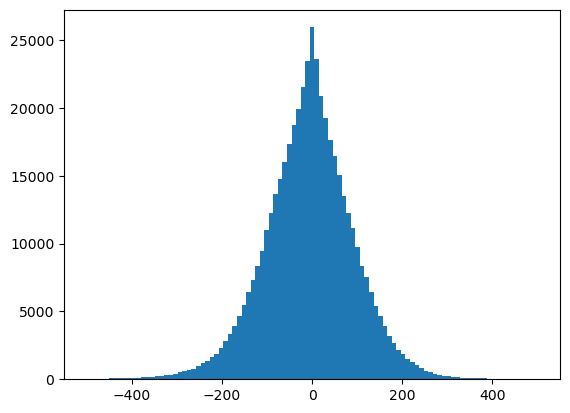

In [28]:
plt.hist(ace_1min_14_22['1 Min ACE Average'][:3805687//8],bins = np.linspace(-500,500,100))
plt.show()

doesn't look normal...

#### Plot time series small part of data

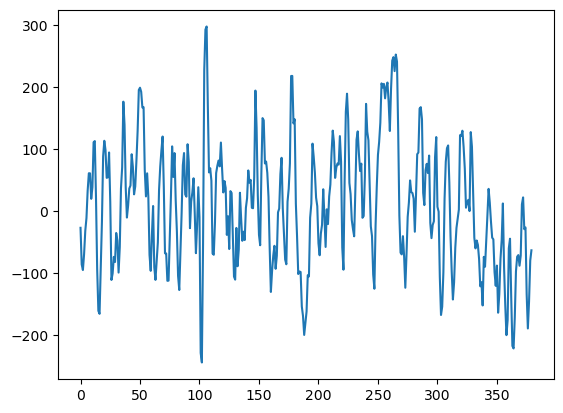

In [27]:
plt.plot(ace_1min_14_22['1 Min ACE Average'][:3805687//10000])

#### limit to 2014 data

In [32]:
# limit to just 2014
ace_1min_14= ace_1min_14_15[ace_1min_14_15["GMTTime"]<"2015-01-01"]

#### Convert  time

In [41]:
import datetime

In [ ]:
# https://www.digitalocean.com/community/tutorials/python-string-to-datetime-strptime
# https://www.geeksforgeeks.org/python-convert-string-to-datetime-and-vice-versa/
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

In [45]:
ace_1min_14["GMTTime"][0]
#'%Y-%m-%dT%H:%M:%S%Z'

'2014-03-01T06:00:00Z'

In [49]:
datetime.datetime.strptime(ace_1min_14["GMTTime"][0],'%Y-%m-%dT%H:%M:%SZ')

datetime.datetime(2014, 3, 1, 6, 0)

Datetime module doesn't work well, 
use pandas method instead

In [51]:
#https://www.geeksforgeeks.org/convert-the-column-type-from-string-to-datetime-format-in-pandas-dataframe/https://www.geeksforgeeks.org/convert-the-column-type-from-string-to-datetime-format-in-pandas-dataframe/
ace_1min_14['datetime'] = pd.to_datetime(ace_1min_14["GMTTime"])

C:\Users\chen5\AppData\Local\Temp\ipykernel_20340\10540153.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ace_1min_14['datetime'] = pd.to_datetime(ace_1min_14["GMTTime"])


#### Look at gaps/time irregularities (not 1 minute difference)

In [55]:
diff_time = ace_1min_14["datetime"].diff()

In [59]:
diff_time!= diff_time[100]

0          True
1         False
2         False
3         False
4         False
          ...  
434167    False
434168    False
434169    False
434170    False
434171    False
Name: datetime, Length: 434172, dtype: bool

In [67]:
ace_1min_14_gaps = ace_1min_14[diff_time!= diff_time[100]]

<AxesSubplot:xlabel='datetime'>

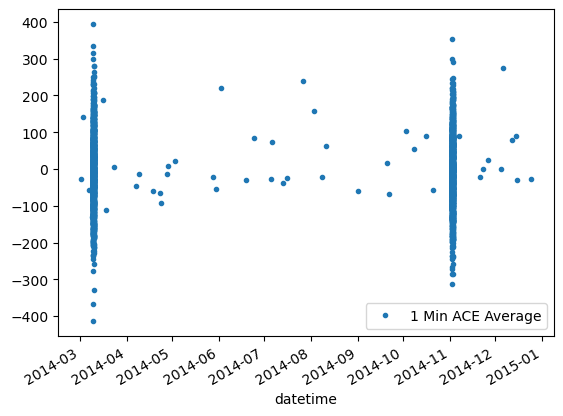

In [72]:
ace_1min_14_gaps.set_index('datetime').plot(style = '.')

most gaps are in two periods, others are scattered.

In [65]:
diff_time[1:][diff_time!= diff_time[100]]

2336               0 days 00:02:00
7958               0 days 00:02:00
10702              0 days 00:02:00
11518    0 days 00:00:57.498278400
11519    0 days 00:00:57.498252800
                    ...           
398399             0 days 07:26:00
406463             0 days 09:37:00
410234             0 days 09:10:00
410703             0 days 03:02:00
424352             0 days 00:02:00
Name: datetime, Length: 2923, dtype: timedelta64[ns]

In [87]:
ace_1min_14_big_gaps = ace_1min_14[diff_time> 2*diff_time[100]]

<AxesSubplot:xlabel='datetime'>

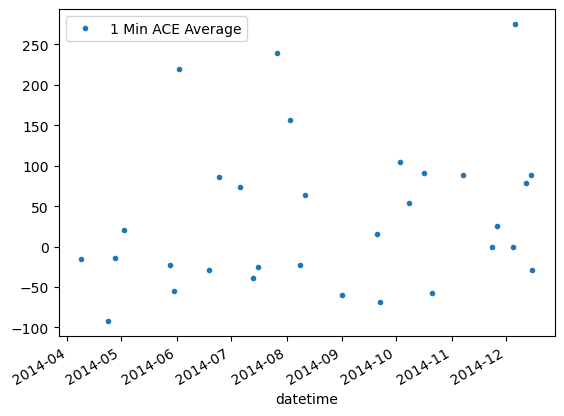

In [89]:
ace_1min_14_big_gaps.set_index('datetime').plot(style = '.')

In [85]:
(diff_time[1:][diff_time> 2*diff_time[100]])

55462    0 days 00:26:00
76624    0 days 00:29:00
82637    0 days 00:03:00
89872    0 days 00:51:00
126217   0 days 03:20:00
128920   0 days 03:32:00
133608   0 days 00:45:00
157091   0 days 02:22:00
165036   0 days 00:14:00
182086   0 days 01:10:00
192459   0 days 03:46:00
196252   0 days 00:10:00
210814   0 days 03:45:00
221501   0 days 04:47:00
229327   0 days 01:10:00
233231   0 days 00:20:00
262944   0 days 00:30:00
290429   0 days 03:57:00
292567   0 days 07:39:00
308617   0 days 01:15:00
315739   0 days 01:19:00
327589   0 days 03:58:00
333964   0 days 04:19:00
357828   0 days 06:22:00
380770   0 days 02:00:00
384721   0 days 07:04:00
396729   0 days 07:17:00
398399   0 days 07:26:00
406463   0 days 09:37:00
410234   0 days 09:10:00
410703   0 days 03:02:00
Name: datetime, dtype: timedelta64[ns]

(array([9., 4., 2., 5., 4., 0., 1., 4., 0., 2.]),
 array([  3. ,  60.4, 117.8, 175.2, 232.6, 290. , 347.4, 404.8, 462.2,
        519.6, 577. ]),
 <BarContainer object of 10 artists>)

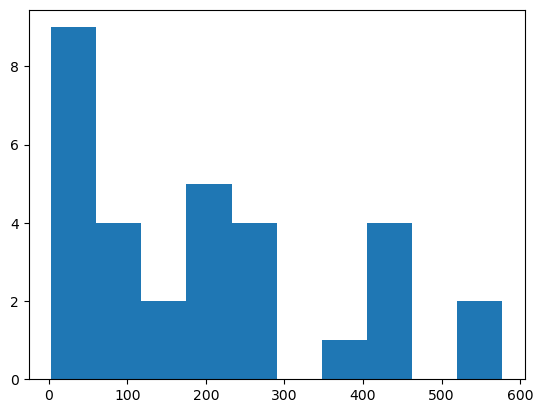

In [84]:
plt.hist((diff_time[1:][diff_time> 2*diff_time[100]]).astype('timedelta64[m]'))


In [78]:
 2*diff_time[100]

Timedelta('0 days 00:02:00')

only 31 intervals have mroe than 2 minute difference

In [63]:
2924/434172

0.006734658153911353

there are gaps, .6% of rows have a gap before them in 2014

In [75]:
ace_1min_14_gaps[:20]

,GMTTime,1 Min ACE Average,datetime
0,2014-03-01T06:00:00Z,-26.9910,2014-03-01 06:00:00+00:00
2336,2014-03-02T20:57:00Z,140.7700,2014-03-02 20:57:00+00:00
7958,2014-03-06T18:40:00Z,-56.5030,2014-03-06 18:40:00+00:00
10702,2014-03-08T16:25:00Z,-131.3800,2014-03-08 16:25:00+00:00
11518,2014-03-09T06:00:57.4982784Z,-60.1820,2014-03-09 06:00:57.498278400+00:00
11519,2014-03-09T06:01:54.9965312Z,-132.8300,2014-03-09 06:01:54.996531200+00:00
11520,2014-03-09T06:02:52.4947968Z,-149.0600,2014-03-09 06:02:52.494796800+00:00
11521,2014-03-09T06:03:49.9930624Z,-118.0400,2014-03-09 06:03:49.993062400+00:00
11522,2014-03-09T06:04:47.4913152Z,20.2490,2014-03-09 06:04:47.491315200+00:00
11523,2014-03-09T06:05:44.9895808Z,52.4270,2014-03-09 06:05:44.989580800+00:00


####  Look for NaNs

In [105]:
ace_1min_14[np.logical_not(np.isfinite(ace_1min_14['1 Min ACE Average']))]

,GMTTime,1 Min ACE Average,datetime
325164,2014-10-14T18:05:00Z,NaN,2014-10-14 18:05:00+00:00
357618,2014-11-06T16:14:00Z,NaN,2014-11-06 16:14:00+00:00
357619,2014-11-06T16:15:00Z,NaN,2014-11-06 16:15:00+00:00
357620,2014-11-06T16:16:00Z,NaN,2014-11-06 16:16:00+00:00
357621,2014-11-06T16:17:00Z,NaN,2014-11-06 16:17:00+00:00
357622,2014-11-06T16:18:00Z,NaN,2014-11-06 16:18:00+00:00
357623,2014-11-06T16:19:00Z,NaN,2014-11-06 16:19:00+00:00
368955,2014-11-14T19:32:00Z,NaN,2014-11-14 19:32:00+00:00
368956,2014-11-14T19:33:00Z,NaN,2014-11-14 19:33:00+00:00
368957,2014-11-14T19:34:00Z,NaN,2014-11-14 19:34:00+00:00


In [107]:
# https://thispointer.com/pandas-select-rows-with-nan-in-column/
ace_1min_14[ace_1min_14['1 Min ACE Average'].isnull()]

,GMTTime,1 Min ACE Average,datetime
325164,2014-10-14T18:05:00Z,NaN,2014-10-14 18:05:00+00:00
357618,2014-11-06T16:14:00Z,NaN,2014-11-06 16:14:00+00:00
357619,2014-11-06T16:15:00Z,NaN,2014-11-06 16:15:00+00:00
357620,2014-11-06T16:16:00Z,NaN,2014-11-06 16:16:00+00:00
357621,2014-11-06T16:17:00Z,NaN,2014-11-06 16:17:00+00:00
357622,2014-11-06T16:18:00Z,NaN,2014-11-06 16:18:00+00:00
357623,2014-11-06T16:19:00Z,NaN,2014-11-06 16:19:00+00:00
368955,2014-11-14T19:32:00Z,NaN,2014-11-14 19:32:00+00:00
368956,2014-11-14T19:33:00Z,NaN,2014-11-14 19:33:00+00:00
368957,2014-11-14T19:34:00Z,NaN,2014-11-14 19:34:00+00:00


In [109]:
ace_1min_14[ace_1min_14['GMTTime'].isnull()]

,GMTTime,1 Min ACE Average,datetime


there are 14 NaNs

### Check holes and NaNs for all data

In [111]:
ace_1min_14_22

,GMTTime,1 Min ACE Average,datetime
0,2014-03-01T06:00:00Z,-26.9910,2014-03-01 06:00:00+00:00
1,2014-03-01T06:01:00Z,-86.1290,2014-03-01 06:01:00+00:00
2,2014-03-01T06:02:00Z,-95.1770,2014-03-01 06:02:00+00:00
3,2014-03-01T06:03:00Z,-69.5760,2014-03-01 06:03:00+00:00
4,2014-03-01T06:04:00Z,-31.9080,2014-03-01 06:04:00+00:00
...,...,...,...
3805682,2022-10-16T04:55:00Z,111.4383,2022-10-16 04:55:00+00:00
3805683,2022-10-16T04:56:00Z,110.1949,2022-10-16 04:56:00+00:00
3805684,2022-10-16T04:57:00Z,115.4496,2022-10-16 04:57:00+00:00
3805685,2022-10-16T04:58:00Z,108.1516,2022-10-16 04:58:00+00:00


In [110]:
ace_1min_14_22['datetime'] = pd.to_datetime(ace_1min_14_22["GMTTime"])

In [112]:
diff_time = ace_1min_14_22["datetime"].diff()

In [114]:
ace_1min_14_22_gaps = ace_1min_14_22[diff_time!= diff_time[100]]

In [115]:
ace_1min_14_22_gaps

,GMTTime,1 Min ACE Average,datetime
0,2014-03-01T06:00:00Z,-26.9910,2014-03-01 06:00:00+00:00
2336,2014-03-02T20:57:00Z,140.7700,2014-03-02 20:57:00+00:00
7958,2014-03-06T18:40:00Z,-56.5030,2014-03-06 18:40:00+00:00
10702,2014-03-08T16:25:00Z,-131.3800,2014-03-08 16:25:00+00:00
11518,2014-03-09T06:00:57.4982784Z,-60.1820,2014-03-09 06:00:57.498278400+00:00
...,...,...,...
3493211,2022-03-13T05:00:00Z,-178.5683,2022-03-13 05:00:00+00:00
3498620,2022-03-16T23:10:00Z,-189.0903,2022-03-16 23:10:00+00:00
3548799,2022-04-20T19:30:00Z,-77.3896,2022-04-20 19:30:00+00:00
3637982,2022-06-21T17:54:00Z,44.9753,2022-06-21 17:54:00+00:00


<AxesSubplot:xlabel='datetime'>

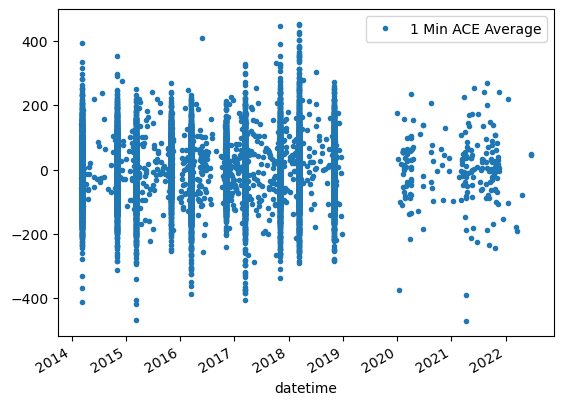

In [116]:
ace_1min_14_22_gaps.set_index('datetime').plot(style = '.')

In [117]:
ace_1min_14_22_big_gaps = ace_1min_14_22[diff_time> 2*diff_time[100]]

<AxesSubplot:xlabel='datetime'>

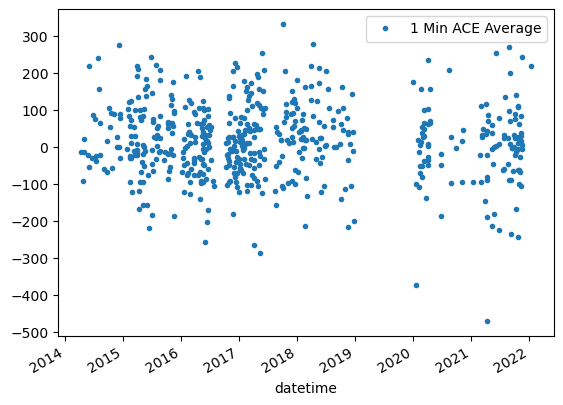

In [118]:
ace_1min_14_22_big_gaps.set_index('datetime').plot(style = '.')

<AxesSubplot:xlabel='datetime'>

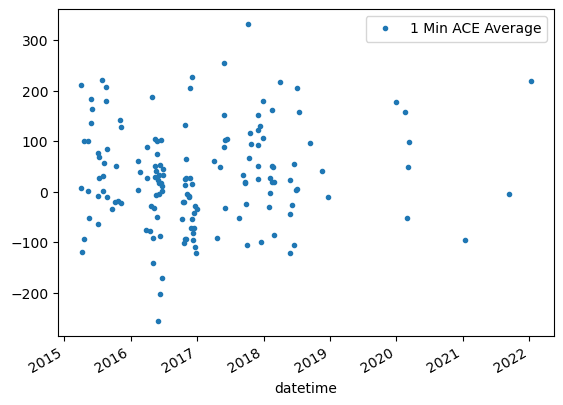

In [136]:
(ace_1min_14_22[diff_time> 600*diff_time[100]]).set_index('datetime').plot(style = '.')

In [133]:
diff_time[1:][diff_time> 2*diff_time[100]].sort_values().tail(50)

1916458     0 days 15:14:00
1342590     0 days 15:17:00
1929519     0 days 15:37:00
1570065     0 days 15:50:00
1764071     0 days 15:53:00
1125011     0 days 15:57:00
1344136     0 days 15:58:00
1350236     0 days 16:00:00
1818525     0 days 16:14:00
1292648     0 days 16:16:00
1520393     0 days 16:19:00
735539      0 days 16:21:00
834998      0 days 16:25:00
1354709     0 days 16:27:00
838255      0 days 16:31:00
1332056     0 days 16:35:00
1728604     0 days 16:37:00
732507      0 days 16:37:00
1768340     0 days 16:47:00
1358685     0 days 16:52:00
678162      0 days 17:03:00
2197630     0 days 17:08:00
1816495     0 days 17:12:00
1919745     0 days 17:13:00
1372876     0 days 17:28:00
1348277     0 days 17:32:00
1736813     0 days 17:33:00
1915931     0 days 17:53:00
1853108     0 days 18:03:00
1368687     0 days 18:07:00
1339565     0 days 18:15:00
1321107     0 days 18:20:00
800100      0 days 18:22:00
1308340     0 days 18:26:00
1333781     0 days 18:56:00
1726720     0 days 1

There are some pretty big gaps in the data

(array([557.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([3.000000e+00, 5.256280e+04, 1.051226e+05, 1.576824e+05,
        2.102422e+05, 2.628020e+05, 3.153618e+05, 3.679216e+05,
        4.204814e+05, 4.730412e+05, 5.256010e+05]),
 <BarContainer object of 10 artists>)

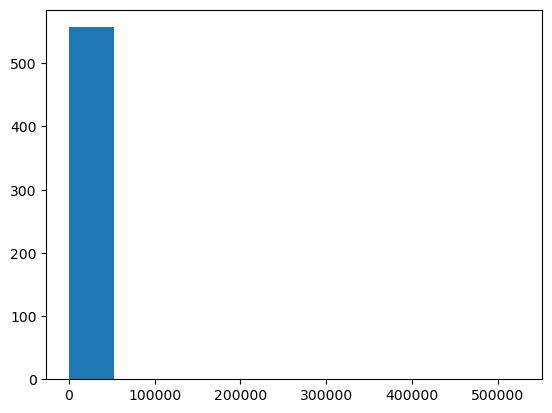

In [119]:
plt.hist((diff_time[1:][diff_time> 2*diff_time[100]]).astype('timedelta64[m]'))


In [137]:
ace_1min_14_22[ace_1min_14_22['1 Min ACE Average'].isnull()]

,GMTTime,1 Min ACE Average,datetime
325164,2014-10-14T18:05:00Z,NaN,2014-10-14 18:05:00+00:00
357618,2014-11-06T16:14:00Z,NaN,2014-11-06 16:14:00+00:00
357619,2014-11-06T16:15:00Z,NaN,2014-11-06 16:15:00+00:00
357620,2014-11-06T16:16:00Z,NaN,2014-11-06 16:16:00+00:00
357621,2014-11-06T16:17:00Z,NaN,2014-11-06 16:17:00+00:00
...,...,...,...
1133064,2016-06-29T23:21:00Z,NaN,2016-06-29 23:21:00+00:00
1133065,2016-06-29T23:22:00Z,NaN,2016-06-29 23:22:00+00:00
1133066,2016-06-29T23:23:00Z,NaN,2016-06-29 23:23:00+00:00
1133067,2016-06-29T23:24:00Z,NaN,2016-06-29 23:24:00+00:00


In [139]:
ace_1min_14_22_nan_removed = ace_1min_14_22[np.logical_not(ace_1min_14_22['1 Min ACE Average'].isnull())]

In [140]:
ace_1min_14_22_nan_removed.to_pickle("ace_1min_14_22_nan_removed.pkl")

In [ ]:
#ace_1min_14_22_nan_removed = pd.read_pickle("ace_1min_14_22_nan_removed.pkl")


There are 109 NaNs in data

(check original source? Probably not worth it)

In [141]:
ace_1min_14_22_nan_removed

,GMTTime,1 Min ACE Average,datetime
0,2014-03-01T06:00:00Z,-26.9910,2014-03-01 06:00:00+00:00
1,2014-03-01T06:01:00Z,-86.1290,2014-03-01 06:01:00+00:00
2,2014-03-01T06:02:00Z,-95.1770,2014-03-01 06:02:00+00:00
3,2014-03-01T06:03:00Z,-69.5760,2014-03-01 06:03:00+00:00
4,2014-03-01T06:04:00Z,-31.9080,2014-03-01 06:04:00+00:00
...,...,...,...
3805682,2022-10-16T04:55:00Z,111.4383,2022-10-16 04:55:00+00:00
3805683,2022-10-16T04:56:00Z,110.1949,2022-10-16 04:56:00+00:00
3805684,2022-10-16T04:57:00Z,115.4496,2022-10-16 04:57:00+00:00
3805685,2022-10-16T04:58:00Z,108.1516,2022-10-16 04:58:00+00:00
